# Assistants with Google Gemini

Gemini is family of Generative AI Models built by Google. It support upto 1 Million tokens as of now. Gemini is now natively supported in Autogen.

This notebook will demonstrate few samples of Autogen with Gemini Models.

## Requirements

You must have a [API Key](https://aistudio.google.com/app/apikey) from Google AI.

## Setup Gemini config list

The list of all supported Gemini Models along with OpenAI's gtp-4o,

```python
config_list = [
    {
        'model': 'gpt-4o',
        'api_key': '<your OpenAI API key here>',
        'tags': ['tool', 'gpt-4'],
    },
    {
        'model': 'gemini-1.5-pro',
        'api_key': '<your Google AI API key here>',
        'api_type': 'google',
        'tags': ['tool', 'gemini'],
    },
    {
        'model': 'gemini-1.5-flash',
        'api_key': '<your Google AI API key here>',
        'api_type': 'google',
        'tags': ['tool', 'gemini'],
    },
    {
        'model': 'gemini-1.0-pro',
        'api_key': '<your Google AI API key here>',
        'api_type': 'google',
        'tags': ['gemini'],
    }
]
```


## Hello World Example

Our first example will be with a simple `UserProxyAgent` asking a question to an `AssistantAgent`. This is based on the tutorial demo [here](https://microsoft.github.io/autogen/docs/tutorial/introduction).

After sending the question and seeing a response, you can type `exit` to end the chat or continue to converse.

In [10]:
import autogen

config_list = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={"tags": ["gemini"]}
)

llm_config = {
    "config_list": config_list,
    "timeout": 120
}

# Create Assistant and User
assistant = autogen.AssistantAgent(name="assistant", llm_config=llm_config)

user_proxy = autogen.UserProxyAgent(name="user", code_execution_config=False)

# Initiate chat from user_proxy side
chat_result = user_proxy.initiate_chat(assistant, message="Hi, what is a LLM ?")

user (to assistant):

Hi, what is a LLM ?

--------------------------------------------------------------------------------
assistant (to user):

A large language model (LLM) is a type of artificial intelligence (AI) system that excels at natural language processing (NLP) tasks. These models are trained on massive text datasets, enabling them to understand, interpret, and generate human-like text in response to a wide range of prompts and questions. 

Here are some key characteristics and capabilities of LLMs:

* **Text Generation:** LLMs can generate coherent and contextually relevant text, including stories, articles, summaries, and conversations.
* **Language Translation:** They can translate text between multiple languages with impressive accuracy.
* **Question Answering:** LLMs can comprehend questions and provide relevant answers based on their training data.
* **Summarization:** They can condense large amounts of text into concise summaries while preserving key information.
* **

## In a Group Chat with OpenAI

Here is an example of Gemini participating in a Group Cat with a GPT-4

In [1]:
import autogen

gpt_config_list = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={"tags": ["gpt-4"]}
)

gpt_llm_config = {
    "config_list": gpt_config_list,
    "timeout": 120
}

gemini_config_list = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={"tags": ["gemini"]}
)

gemini_llm_config = {
    "config_list": gemini_config_list,
    "timeout": 120
}

user_proxy = autogen.UserProxyAgent(
    name="User_proxy",
    system_message="A human admin.",
    code_execution_config={
        "last_n_messages": 2,
        "work_dir": "groupchat",
        "use_docker": False,
    },  # Please set use_docker=True if docker is available to run the generated code. Using docker is safer than running the generated code directly.
    human_input_mode="TERMINATE",
)
coder = autogen.AssistantAgent(
    name="Coder",
    llm_config=gpt_llm_config,
)
pm = autogen.AssistantAgent(
    name="Product_manager",
    system_message="Creative in software product ideas.",
    llm_config=gemini_llm_config,
)
groupchat = autogen.GroupChat(agents=[user_proxy, coder, pm], messages=[], max_round=12)
manager = autogen.GroupChatManager(groupchat=groupchat, llm_config=gpt_llm_config)
user_proxy.initiate_chat(
    manager, message="Find a latest paper about gpt-4 on arxiv and find its potential applications in software."
)

c:\Users\arjun\anaconda3\envs\autogen\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


User_proxy (to chat_manager):

Find a latest paper about gpt-4 on arxiv and find its potential applications in software.

--------------------------------------------------------------------------------

Next speaker: User_proxy


>>>>>>>> USING AUTO REPLY...
User_proxy (to chat_manager):



--------------------------------------------------------------------------------

Next speaker: User_proxy


>>>>>>>> USING AUTO REPLY...
User_proxy (to chat_manager):



--------------------------------------------------------------------------------

Next speaker: Coder

Coder (to chat_manager):

Let's start by searching for the latest paper about GPT-4 on arXiv. We can use the arXiv API to fetch the latest paper related to GPT-4.

I'll provide a Python script to search arXiv for the latest papers related to "GPT-4."

```python
import requests
from xml.etree import ElementTree

# arXiv API url for querying papers related to GPT-4
url = "http://export.arxiv.org/api/query?search_query=ti:GPT-4&star

ChatResult(chat_id=None, chat_history=[{'content': 'Find a latest paper about gpt-4 on arxiv and find its potential applications in software.', 'role': 'assistant'}, {'content': '', 'role': 'assistant'}, {'content': '', 'role': 'assistant'}, {'content': 'Let\'s start by searching for the latest paper about GPT-4 on arXiv. We can use the arXiv API to fetch the latest paper related to GPT-4.\n\nI\'ll provide a Python script to search arXiv for the latest papers related to "GPT-4."\n\n```python\nimport requests\nfrom xml.etree import ElementTree\n\n# arXiv API url for querying papers related to GPT-4\nurl = "http://export.arxiv.org/api/query?search_query=ti:GPT-4&start=0&max_results=1&sortBy=submittedDate&sortOrder=descending"\n\nresponse = requests.get(url)\nif response.status_code == 200:\n    root = ElementTree.fromstring(response.content)\n    entry = root.find("{http://www.w3.org/2005/Atom}entry")\n    if entry is not None:\n        title = entry.find("{http://www.w3.org/2005/Atom}ti

## Function Calling with Gemini

Here is an example of Gemini with Function Calling,

user_proxy (to chatbot):

Draw two agents chatting with each other with an example dialog. Don't add plt.show().

--------------------------------------------------------------------------------
chatbot (to user_proxy):

***** Suggested tool call (call_l7Rz8YLE4F2y8nGLCaroD6XL): python *****
Arguments: 
{
  "cell": `
import matplotlib.pyplot as plt

# Create figure and axes
fig, ax = plt.subplots()

# Define agent coordinates
agent1_x, agent1_y = 1, 1
agent2_x, agent2_y = 3, 1

# Draw agents as circles
agent1 = plt.Circle((agent1_x, agent1_y), 0.1, color='blue')
agent2 = plt.Circle((agent2_x, agent2_y), 0.1, color='green')
ax.add_patch(agent1)
ax.add_patch(agent2)

# Add example dialog
dialog1 = "Hi, how are you?"
dialog2 = "I'm good, thanks!"

# Add text labels for the dialog
plt.text(agent1_x, agent1_y + 0.3, dialog1, fontsize=12, ha='center')
plt.text(agent2_x, agent2_y + 0.3, dialog2, fontsize=12, ha='center')

# Set limits and turn off the axes
ax.set_xlim(0, 4)
ax.set_ylim(0, 2)


(0.0, 4.0, 0.0, 2.0)

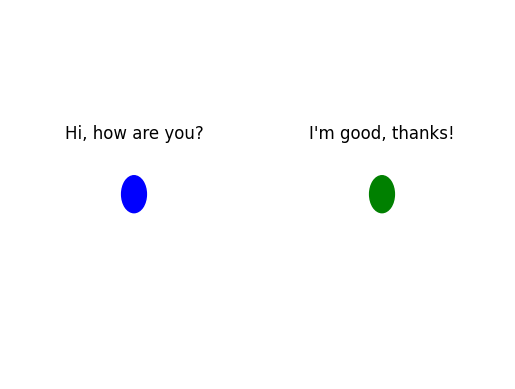

user_proxy (to chatbot):

user_proxy (to chatbot):

***** Response from calling tool (call_VjzGKf34UMKMlSHCrQpJ6ICK) *****
(0.0, 4.0, 0.0, 2.0)
**********************************************************************

--------------------------------------------------------------------------------
chatbot (to user_proxy):

TERMINATE

--------------------------------------------------------------------------------


In [5]:
from IPython import get_ipython
from typing_extensions import Annotated

import autogen
from autogen.cache import Cache

config_list = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={"tags": ["gemini", "tool"]}
)

llm_config = {
    "config_list": config_list,
    "timeout": 120,
}
chatbot = autogen.AssistantAgent(
    name="chatbot",
    system_message="For coding tasks, only use the functions you have been provided with. Reply TERMINATE when the task is done.",
    llm_config=llm_config,
)

# create a UserProxyAgent instance named "user_proxy"
user_proxy = autogen.UserProxyAgent(
    name="user_proxy",
    is_termination_msg=lambda x: x.get("content", "") and x.get("content", "").rstrip().endswith("TERMINATE"),
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10,
    code_execution_config={
        "work_dir": "coding",
        "use_docker": False,
    },  # Please set use_docker=True if docker is available to run the generated code. Using docker is safer than running the generated code directly.
)


# define functions according to the function description


# one way of registering functions is to use the register_for_llm and register_for_execution decorators
@user_proxy.register_for_execution()
@chatbot.register_for_llm(name="python", description="run cell in ipython and return the execution result.")
def exec_python(cell: Annotated[str, "Valid Python cell to execute."]) -> str:
    ipython = get_ipython()
    result = ipython.run_cell(cell)
    log = str(result.result)
    if result.error_before_exec is not None:
        log += f"\n{result.error_before_exec}"
    if result.error_in_exec is not None:
        log += f"\n{result.error_in_exec}"
    return log


# another way of registering functions is to use the register_function
def exec_sh(script: Annotated[str, "Valid Python cell to execute."]) -> str:
    return user_proxy.execute_code_blocks([("sh", script)])


autogen.agentchat.register_function(
    exec_python,
    caller=chatbot,
    executor=user_proxy,
    name="sh",
    description="run a shell script and return the execution result.",
)

with Cache.disk() as cache:
    # start the conversation
    user_proxy.initiate_chat(
        chatbot,
        message="Draw two agents chatting with each other with an example dialog. Don't add plt.show().",
        cache=cache,
        max_turns=3,
    )